# Prelim

Dataset downloaded from : https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_unsorted_10k

Data is available at `s3://fh-pi-setty-m-eco-public/single-cell-primers/multiome/`

ArchR preprocessing script: https://github.com/settylab/single-cell-primers/blob/main/scripts/PBMC-mulitome-ATAC-ArchR-preprocessing.R

Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.

In [3]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

In [4]:
import palantir 
import phenograph
import harmony

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [5]:
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [6]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [7]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

# Load data

## ATAC

In [14]:
data_dir = '/fh/fast/setty_m/user/cjordan2/repositories/single-cell-primers/ArchR/tcell/export/'

Load all the exported results from ArchR

### Peaks data

In [15]:
# Peaks data
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [19]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
gene_scores = pd.read_csv(data_dir + "gene_scores.csv", index_col = 0)
imputed_scores = pd.read_csv(data_dir + 'imputed_scores.csv')
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()


,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,nearestGene,distToGeneStart,peakType,distToTSS,nearestTSS,GC,idx,N
chr1:804692-805192,chr1,804692,805192,501,*,9.69591,0.392,0.182,2,C16._.rep1,FAM87B,12429,Distal,9,uc057aum.1,0.4012,1,0
chr1:816087-816587,chr1,816087,816587,501,*,26.63992,0.543,0.409,2,C5._.rep1,FAM87B,1034,Promoter,1033,uc057aum.1,0.2894,2,0
chr1:817091-817591,chr1,817091,817591,501,*,260.66299,0.909,0.882,2,C7._.rep2,FAM87B,30,Promoter,29,uc057aum.1,0.4770,3,0
chr1:821117-821617,chr1,821117,821617,501,*,5.45201,0.300,0.092,2,C2._.rep2,FAM87B,3996,Distal,3770,uc057aum.1,0.5489,4,0
chr1:822007-822507,chr1,822007,822507,501,*,8.14237,0.466,0.210,2,C2._.rep1,FAM87B,4886,Distal,2880,uc057aum.1,0.5509,5,0


In [65]:
deviations = pd.read_csv(data_dir + "deviations.csv", index_col = 0)
deviations

,seqnames,idx,name,combinedVars,combinedMeans,rank
f383,z,383,GATA1_383,71.799761,0.098866,1
f388,z,388,GATA2_388,70.111018,0.121629,2
f385,z,385,GATA5_385,63.466051,0.117983,3
f384,z,384,GATA3_384,61.899082,0.108888,4
f386,z,386,GATA4_386,33.003536,0.097778,5
...,...,...,...,...,...,...
f266,z,266,WT1_266,0.488046,0.006753,866
f222,z,222,ZNF148_222,0.477954,-0.004392,867
f299,z,299,KDM2B_299,NaN,NaN,868
f302,z,302,TET1_302,NaN,inf,869


In [67]:
motif_scores = pd.read_csv(data_dir + "motif_scores.csv", index_col = 0 )
motif_scores

,rep1#GTGAGCGAGTCTCACC-1,rep1#GAGTCAAAGTCCTTCA-1,rep1#ATTAGCTCATTGTCCT-1,rep1#TGTGCGCAGTCGCTAG-1,rep1#TATTAGGTCGTTTCCA-1,rep1#GACTATTCACGAATTT-1,rep1#GAAAGGCTCACTAAGC-1,rep1#ATATGTCCAATGCCTA-1,rep1#CTTTCTTGTCTATCGT-1,rep1#TAGTGGCGTTAGGCGT-1,...,rep2#AAACCGAAGTGAACAG-1,rep2#CCAAACCCATAATGTC-1,rep2#CTATTACTCTCACTAT-1,rep2#GAACCAGCATAAGGAC-1,rep2#CCGTTATGTTGAGGTC-1,rep2#GAAGGCCCAGGAATCG-1,rep2#ACCTAAATCGCAGGCT-1,rep2#CACTTTGTCCGTGACA-1,rep2#CGCCTGTGTATCTGGA-1,rep2#CTAGTGAGTCATCATC-1
GATA1_383,-3.759658,51.121760,-0.325811,19.998358,-5.479198,-0.851844,11.656643,-5.799450,-7.372774,10.949669,...,-0.498200,1.162775,-0.870864,-1.619414,1.543635,1.932786,-1.573062,1.112312,0.945319,0.537629
GATA2_388,-3.435107,54.951476,0.008507,20.034330,-5.889414,-0.358458,10.516516,-4.176654,-8.026294,11.913123,...,1.121575,1.623704,-0.818156,-0.866682,0.054338,1.583000,-1.779682,1.011522,1.032787,0.754555
GATA5_385,-3.374332,44.942518,-0.353318,20.437595,-4.912004,-1.067627,11.279273,-4.375865,-6.896126,10.703975,...,0.561161,2.231697,-1.094900,-1.125623,1.398434,-0.070960,-1.662395,0.138033,-0.306956,-1.549246
GATA3_384,-4.324169,44.985326,-1.143331,20.424420,-5.459371,-2.123394,10.692167,-3.508455,-7.179040,9.244005,...,0.437091,1.136606,0.209108,-0.252507,2.005358,-0.238303,-1.604017,0.036012,-0.322002,-0.646374
GATA4_386,-1.851462,31.794212,-0.189965,12.723165,-3.169673,1.098896,5.728785,-2.682370,-3.593233,9.536304,...,-1.325869,-0.023439,0.047987,-0.142142,0.407943,-1.222131,-0.784151,-1.433372,0.487093,-0.990086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT1_266,-1.240679,-0.664296,-0.021024,-2.483087,0.323313,-0.845267,-0.661939,-0.968677,-2.480949,-1.358243,...,-0.462670,-0.518207,0.318394,-0.501014,-0.627798,0.056072,0.294538,0.407511,-0.841133,0.074405
ZNF148_222,-0.535946,-0.920723,0.107637,-1.859865,0.541219,-2.706436,-1.364662,0.666560,-1.460426,0.154519,...,-0.634971,0.350739,-0.664712,-0.749832,-0.103913,-0.339784,0.030766,-0.711772,-0.553061,-0.136596
KDM2B_299,-0.622551,-1.044483,0.011221,0.865017,0.627689,0.290675,0.347444,-0.819630,-2.823297,-0.334669,...,2.378691,1.268248,-0.542426,-0.393889,-0.407753,1.350840,-0.622706,-0.305904,-0.447148,-0.510617
TET1_302,-0.974828,-0.697501,0.500542,0.229544,-0.202060,1.859255,-0.260583,0.569034,-0.270590,-0.277424,...,-0.541385,-0.586513,-0.460758,-0.485714,1.298109,-0.516950,-0.583616,-0.441490,-0.456571,-0.468536


In [38]:
gene_scores = pd.read_csv(data_dir + "gene_scores.csv", index_col = 0)

In [39]:
gene_scores

,rep1#GTGAGCGAGTCTCACC-1,rep1#GAGTCAAAGTCCTTCA-1,rep1#ATTAGCTCATTGTCCT-1,rep1#TGTGCGCAGTCGCTAG-1,rep1#TATTAGGTCGTTTCCA-1,rep1#GACTATTCACGAATTT-1,rep1#GAAAGGCTCACTAAGC-1,rep1#ATATGTCCAATGCCTA-1,rep1#CTTTCTTGTCTATCGT-1,rep1#TAGTGGCGTTAGGCGT-1,...,rep2#AAACCGAAGTGAACAG-1,rep2#CCAAACCCATAATGTC-1,rep2#CTATTACTCTCACTAT-1,rep2#GAACCAGCATAAGGAC-1,rep2#CCGTTATGTTGAGGTC-1,rep2#GAAGGCCCAGGAATCG-1,rep2#ACCTAAATCGCAGGCT-1,rep2#CACTTTGTCCGTGACA-1,rep2#CGCCTGTGTATCTGGA-1,rep2#CTAGTGAGTCATCATC-1
OR4F5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LOC729737,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LOC101928626,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM87B,0.000,0.192,0.208,0.000,0.181,0.195,0.000,0.000,0.219,0.196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC01128,0.085,0.242,0.464,0.098,0.236,0.175,0.291,0.111,0.183,0.321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RAB39B,0.318,0.296,0.000,0.360,0.144,0.000,0.232,0.000,0.000,0.044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CLIC2,0.074,0.140,0.074,0.085,0.068,0.000,0.337,0.000,0.240,0.140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H2AFB1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F8A2,0.000,0.188,0.000,0.150,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
imputed_scores.index=gene_scores.index

In [41]:
imputed_scores

,rep1.GTGAGCGAGTCTCACC.1,rep1.GAGTCAAAGTCCTTCA.1,rep1.ATTAGCTCATTGTCCT.1,rep1.TGTGCGCAGTCGCTAG.1,rep1.TATTAGGTCGTTTCCA.1,rep1.GACTATTCACGAATTT.1,rep1.GAAAGGCTCACTAAGC.1,rep1.ATATGTCCAATGCCTA.1,rep1.CTTTCTTGTCTATCGT.1,rep1.TAGTGGCGTTAGGCGT.1,...,rep2.AAACCGAAGTGAACAG.1,rep2.CCAAACCCATAATGTC.1,rep2.CTATTACTCTCACTAT.1,rep2.GAACCAGCATAAGGAC.1,rep2.CCGTTATGTTGAGGTC.1,rep2.GAAGGCCCAGGAATCG.1,rep2.ACCTAAATCGCAGGCT.1,rep2.CACTTTGTCCGTGACA.1,rep2.CGCCTGTGTATCTGGA.1,rep2.CTAGTGAGTCATCATC.1
OR4F5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LOC729737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LOC101928626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FAM87B,0.125117,0.054901,0.090318,0.043440,0.068706,0.098938,0.080039,0.197961,0.201942,0.092292,...,0.082964,0.087747,0.125250,0.049428,0.079654,0.109604,0.100527,0.149663,0.121147,0.084838
LINC01128,0.146076,0.222153,0.220606,0.449691,0.163555,0.245286,0.345116,0.150358,0.156237,0.163670,...,0.115339,0.123658,0.153971,0.131524,0.143200,0.100711,0.181570,0.189444,0.104706,0.079403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RAB39B,0.128434,0.135206,0.094545,0.104696,0.124655,0.109280,0.107364,0.069321,0.083740,0.135985,...,0.016884,0.018097,0.001342,0.035550,0.051184,0.031329,0.004182,0.024515,0.044643,0.044420
CLIC2,0.054955,0.112163,0.027072,0.185894,0.019591,0.017491,0.161856,0.018647,0.052985,0.064689,...,0.040195,0.035371,0.027174,0.050763,0.100009,0.047421,0.029674,0.060895,0.061134,0.036810
H2AFB1,0.000000,0.000000,0.000000,0.000000,0.000018,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F8A2,0.028020,0.104352,0.016383,0.072058,0.019468,0.016929,0.055353,0.014976,0.013222,0.033261,...,0.118269,0.121669,0.144456,0.074492,0.018198,0.154657,0.142372,0.080124,0.013979,0.021374


In [70]:
ad.obs

,Sample,TSSEnrichment,ReadsInTSS,ReadsInPromoter,ReadsInBlacklist,PromoterRatio,PassQC,NucleosomeRatio,nMultiFrags,nMonoFrags,nFrags,nDiFrags,BlacklistRatio,Clusters,ReadsInPeaks,FRIP,leiden,phenograph
x,,,,,,,,,,,,,,,,,,
rep1#GTGAGCGAGTCTCACC-1,rep1,8.519,25098,27395,1112,0.137123,1,1.817828,14916,35450,99892,49526,0.005566,C3,47750,0.670759,8,9
rep1#GAGTCAAAGTCCTTCA-1,rep1,9.182,32537,35044,1132,0.176802,1,1.489262,13094,39813,99105,46198,0.005711,C1,46373,0.580911,15,13
rep1#ATTAGCTCATTGTCCT-1,rep1,12.532,42091,42307,1327,0.214486,1,1.609239,13488,37798,98624,47338,0.006728,C16,54926,0.724426,11,7
rep1#TGTGCGCAGTCGCTAG-1,rep1,6.137,14356,16542,902,0.084618,1,4.444797,16184,17952,97745,63609,0.004614,C2,15113,0.419247,11,8
rep1#TATTAGGTCGTTTCCA-1,rep1,14.597,57173,55576,1337,0.284967,1,1.022420,12204,48216,97513,37093,0.006855,C18,75802,0.784132,10,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rep2#GAAGGCCCAGGAATCG-1,rep2,5.743,58,66,4,0.032967,1,3.789474,140,209,1001,652,0.001998,C13,69,0.165072,0,0
rep2#ACCTAAATCGCAGGCT-1,rep2,8.281,92,70,26,0.035000,1,2.367003,113,297,1000,590,0.013000,C13,80,0.135593,0,0
rep2#CACTTTGTCCGTGACA-1,rep2,4.158,42,41,2,0.020500,1,3.629630,142,216,1000,642,0.001000,C13,48,0.109091,0,0


In [42]:
#np.shape(imputed_scores)
np.shape(gene_scores)

(24919, 13355)

In [43]:
imputed_scores.columns = gene_scores.columns

In [44]:
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]

/loc/scratch/66335749/ipykernel_32522/1812160205.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(counts.T)


In [68]:
ad.uns['deviations'] = deviations

In [45]:
ad.X = ad.X.tocsr()

In [46]:
ad.var_names

Index(['chr1:804692-805192', 'chr1:816087-816587', 'chr1:817091-817591',
       'chr1:821117-821617', 'chr1:822007-822507', 'chr1:827294-827794',
       'chr1:830026-830526', 'chr1:831357-831857', 'chr1:838277-838777',
       'chr1:841647-842147',
       ...
       'chrX:155881629-155882129', 'chrX:155885766-155886266',
       'chrX:155886535-155887035', 'chrX:155888154-155888654',
       'chrX:155889262-155889762', 'chrX:155891403-155891903',
       'chrX:155893517-155894017', 'chrX:155899098-155899598',
       'chrX:155966820-155967320', 'chrX:155968175-155968675'],
      dtype='object', length=285460)

### SVD

In [47]:
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

### Metadata

In [48]:
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

In [49]:
ad

AnnData object with n_obs × n_vars = 13355 × 285460
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    obsm: 'X_svd'

### Gene scores

In [50]:
# Gene scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T

In [51]:
ad.obsm['GeneScores'] = gene_scores.loc[ad.obs_names, :].values
ad.uns['GeneScoresColumns'] = gene_scores.columns.values


In [52]:
ad.obsm['GeneScores']

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.181],
       [0.   , 0.   , 0.   , ..., 0.   , 0.188, 0.016],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.125],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [55]:
ad.obsm['MAGIC_imputed_GeneScores'] = imputed_scores.T.loc[ad.obs_names, :].values

In [56]:
ad

AnnData object with n_obs × n_vars = 13355 × 285460
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColumns'
    obsm: 'X_svd', 'GeneScores', 'MAGIC_imputed_GeneScores'

In [76]:
motif_scores.T

,GATA1_383,GATA2_388,GATA5_385,GATA3_384,GATA4_386,CEBPA_155,CEBPB_140,GATA6_387,CEBPD_152,SPI1_322,...,SP2_232,MAZ_178,SP1_267,ZBTB7A_258,ZFX_158,WT1_266,ZNF148_222,KDM2B_299,TET1_302,ZBED1_816
rep1#GTGAGCGAGTCTCACC-1,-3.759658,-3.435107,-3.374332,-4.324169,-1.851462,5.151548,4.042209,-0.574677,2.513843,2.939708,...,-3.444544,1.071732,-2.987376,0.426308,-2.504207,-1.240679,-0.535946,-0.622551,-0.974828,-1.805723
rep1#GAGTCAAAGTCCTTCA-1,51.121760,54.951476,44.942518,44.985326,31.794212,-13.932001,-12.907940,22.367103,-13.155139,-24.849413,...,-1.523395,-1.368123,-1.523213,-1.314691,1.585121,-0.664296,-0.920723,-1.044483,-0.697501,0.890790
rep1#ATTAGCTCATTGTCCT-1,-0.325811,0.008507,-0.353318,-1.143331,-0.189965,-12.136440,-9.905821,-1.248108,-12.406471,4.008338,...,0.030151,-0.038137,-0.373012,0.708459,-0.489267,-0.021024,0.107637,0.011221,0.500542,0.739426
rep1#TGTGCGCAGTCGCTAG-1,19.998358,20.034330,20.437595,20.424420,12.723165,-6.485179,-6.694989,12.497157,-7.254898,-12.477471,...,-1.541712,-1.869017,-1.199888,-2.667551,0.879236,-2.483087,-1.859865,0.865017,0.229544,-0.268006
rep1#TATTAGGTCGTTTCCA-1,-5.479198,-5.889414,-4.912004,-5.459371,-3.169673,-9.584719,-9.340526,-1.981338,-9.417716,2.088230,...,-0.598518,0.593566,-0.921877,2.530798,-2.597460,0.323313,0.541219,0.627689,-0.202060,-1.421465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rep2#GAAGGCCCAGGAATCG-1,1.932786,1.583000,-0.070960,-0.238303,-1.222131,1.955375,0.094540,0.184902,0.789585,-1.362420,...,0.512730,-0.313026,-0.029119,-0.327685,0.819348,0.056072,-0.339784,1.350840,-0.516950,-0.272677
rep2#ACCTAAATCGCAGGCT-1,-1.573062,-1.779682,-1.662395,-1.604017,-0.784151,1.212634,0.266599,0.557939,0.894290,0.452341,...,0.619274,-0.001464,-0.207718,-1.122308,0.748233,0.294538,0.030766,-0.622706,-0.583616,-0.555700
rep2#CACTTTGTCCGTGACA-1,1.112312,1.011522,0.138033,0.036012,-1.433372,-1.183887,0.502514,0.241480,-0.379911,0.086530,...,0.434144,-0.356940,0.079132,-0.648115,-0.012664,0.407511,-0.711772,-0.305904,-0.441490,-0.280356
rep2#CGCCTGTGTATCTGGA-1,0.945319,1.032787,-0.306956,-0.322002,0.487093,-1.140412,-0.956030,0.389835,-1.170866,-0.623738,...,-0.468735,-0.676018,-0.613697,0.148354,-0.062891,-0.841133,-0.553061,-0.447148,-0.456571,-0.493405


In [77]:
ad.obsm['MotifScores'] = motif_scores.T.loc[ad.obs_names, :].values
ad.uns['MotifScoresColumns'] = motif_scores.T.columns.values

In [78]:
ad.uns['MotifScoresColumns']

array(['GATA1_383', 'GATA2_388', 'GATA5_385', 'GATA3_384', 'GATA4_386',
       'CEBPA_155', 'CEBPB_140', 'GATA6_387', 'CEBPD_152', 'SPI1_322',
       'SPIB_336', 'JUNB_139', 'SMARCC1_651', 'FOSL1_142', 'JUND_124',
       'FOSL2_105', 'JUN_143', 'FOS_137', 'BCL11A_194', 'BCL11B_825',
       'BACH1_130', 'TCF4_97', 'MESP1_69', 'MESP2_94', 'SPIC_344',
       'TCF12_56', 'LMO2_808', 'CEBPG_128', 'ID3_38', 'ID4_75',
       'FOSB_121', 'MECOM_169', 'BACH2_113', 'MYOD1_48', 'JDP2_125',
       'CEBPE_107', 'ATOH8_71', 'SNAI1_199', 'ASCL1_843', 'TCF3_21',
       'NFE2_119', 'ASCL2_89', 'MYOG_41', 'NHLH1_74', 'LYL1_818',
       'NHLH2_80', 'EBF1_67', 'NFE2L2_115', 'NFIX_738', 'ATF4_122',
       'NEUROD1_63', 'RUNX2_732', 'ENSG00000250096_734', 'ZEB1_157',
       'IRF4_632', 'FIGLA_88', 'TAL1_62', 'TAL2_822', 'TFAP4_23',
       'MYF5_842', 'TWIST1_42', 'RELA_722', 'ELF2_326', 'STAT2_778',
       'PRDM16_211', 'IRF1_629', 'FERD3L_58', 'HLF_112', 'CBFB_801',
       'EOMES_788', 'RUNX1_733', 'NFKB1_

# Preprocessing

In [57]:
# Leiden and UMAP
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)
warnings.filterwarnings('default')

In [58]:
# Phenograph
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_svd'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.284379243850708 seconds


/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14b7e1799160>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14b6e5390dc0>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14b7e1799160>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14b6e5390dc0>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14b7e1799160>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70:

Jaccard graph constructed in 2.981372594833374 seconds
Wrote graph to binary file in 0.2782163619995117 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.885647
After 4 runs, maximum modularity is Q = 0.886828
After 7 runs, maximum modularity is Q = 0.888715
Louvain completed 27 runs in 12.70816946029663 seconds
Sorting communities by size, please wait ...


/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14b7e1799160>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14b6e5390dc0>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14b7e1799160>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14b6e5390dc0>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x14b7e1799160>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70:

PhenoGraph completed in 19.91787552833557 seconds


In [59]:
# Diffusion maps
warnings.filterwarnings('ignore')
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_svd'], index=ad.obs_names))
warnings.filterwarnings('default')
ad.obsp['DM_kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors']  = dm_res['EigenVectors'].values
ad.uns['DM_EigenValues']  = dm_res['EigenValues'].values

Determing nearest neighbor graph...


# Visualizations

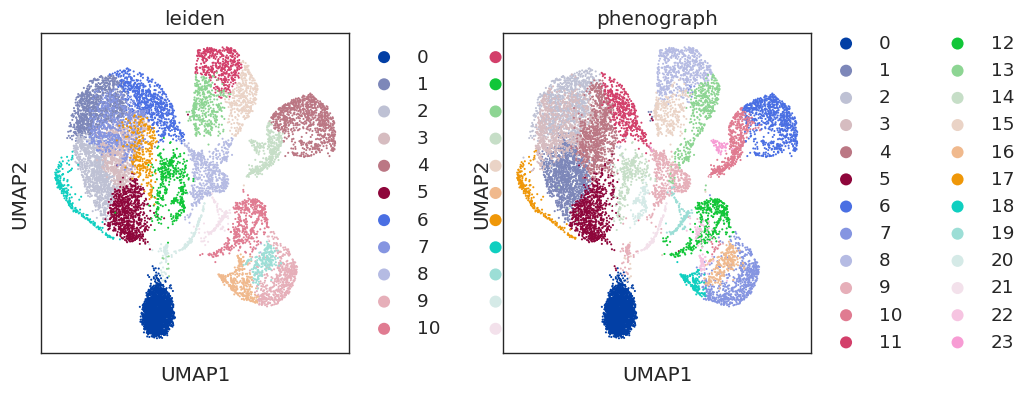

In [60]:
sc.pl.scatter(ad, basis='umap', color=['leiden', 'phenograph'])

# Save

In [79]:
ad

AnnData object with n_obs × n_vars = 13355 × 285460
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColumns', 'neighbors', 'umap', 'leiden', 'DM_EigenValues', 'leiden_colors', 'phenograph_colors', 'deviations', 'MotifScoresColumns'
    obsm: 'X_svd', 'GeneScores', 'MAGIC_imputed_GeneScores', 'X_umap', 'DM_EigenVectors', 'MotifScores'
    obsp: 'distances', 'connectivities', 'DM_kernel'

In [80]:
ad.write('/fh/fast/setty_m/user/cjordan2/repositories/single-cell-primers/data/tcell_dep_multiome_atac_processed.h5ad')